In [ ]:
!pip install -q kaggle kagglehub pandas scikit-learn

# Clonando dataset

In [ ]:
import kagglehub
import pandas as pd


path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

# Treinamento utilizando SVM, Random Forest e MLP. Utilizando Pipeline com Hot Encoding Standard Scaler com Column Transformer.

referencia: https://g.co/gemini/share/f9f80068ef06

In [ ]:
df = pd.read_csv('/kaggle/input/student-depression-dataset/student_depression_dataset.csv')


## Visualização dos dados

/tmp/ipython-input-15-4206946450.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='coolwarm')


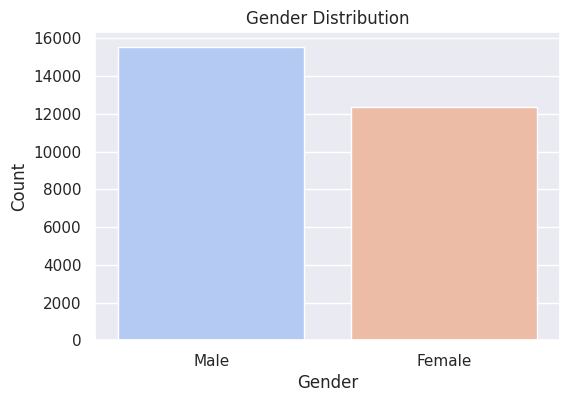

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=df, palette='coolwarm')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

In [ ]:
numerical_features = ["Age", "Academic Pressure", "Work Pressure", "CGPA", "Study Satisfaction", "Job Satisfaction", "Work/Study Hours", "Financial Stress"]
categorical_features = ["Gender", "City", "Degree", "Profession", "Dietary Habits", "Have you ever had suicidal thoughts ?", "Family History of Mental Illness", "Sleep Duration"]

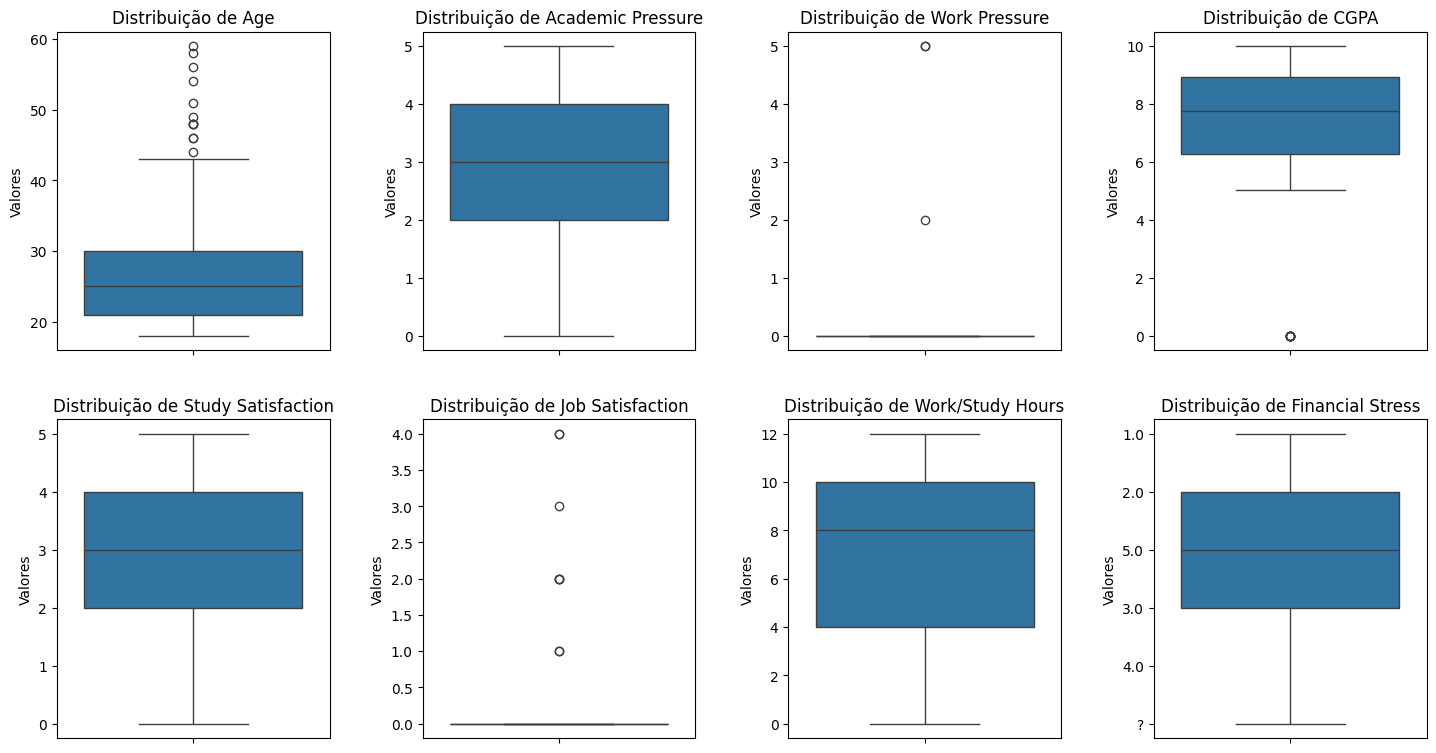

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

n_rows = 3
n_columns = 4
fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 12))

for feature, ax in zip(numerical_features, axes.flatten()):
    sns.boxplot(y=df[feature], ax=ax) # Usar 'y=' cria boxplots verticais
    ax.set_title(f'Distribuição de {feature}', fontsize=12)
    ax.set_xlabel('') # Opcional: remove o nome do eixo x
    ax.set_ylabel('Valores') # Opcional: define um rótulo y padrão

for i in range(len(numerical_features), n_rows * n_columns):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(pad=3.0)

plt.show()


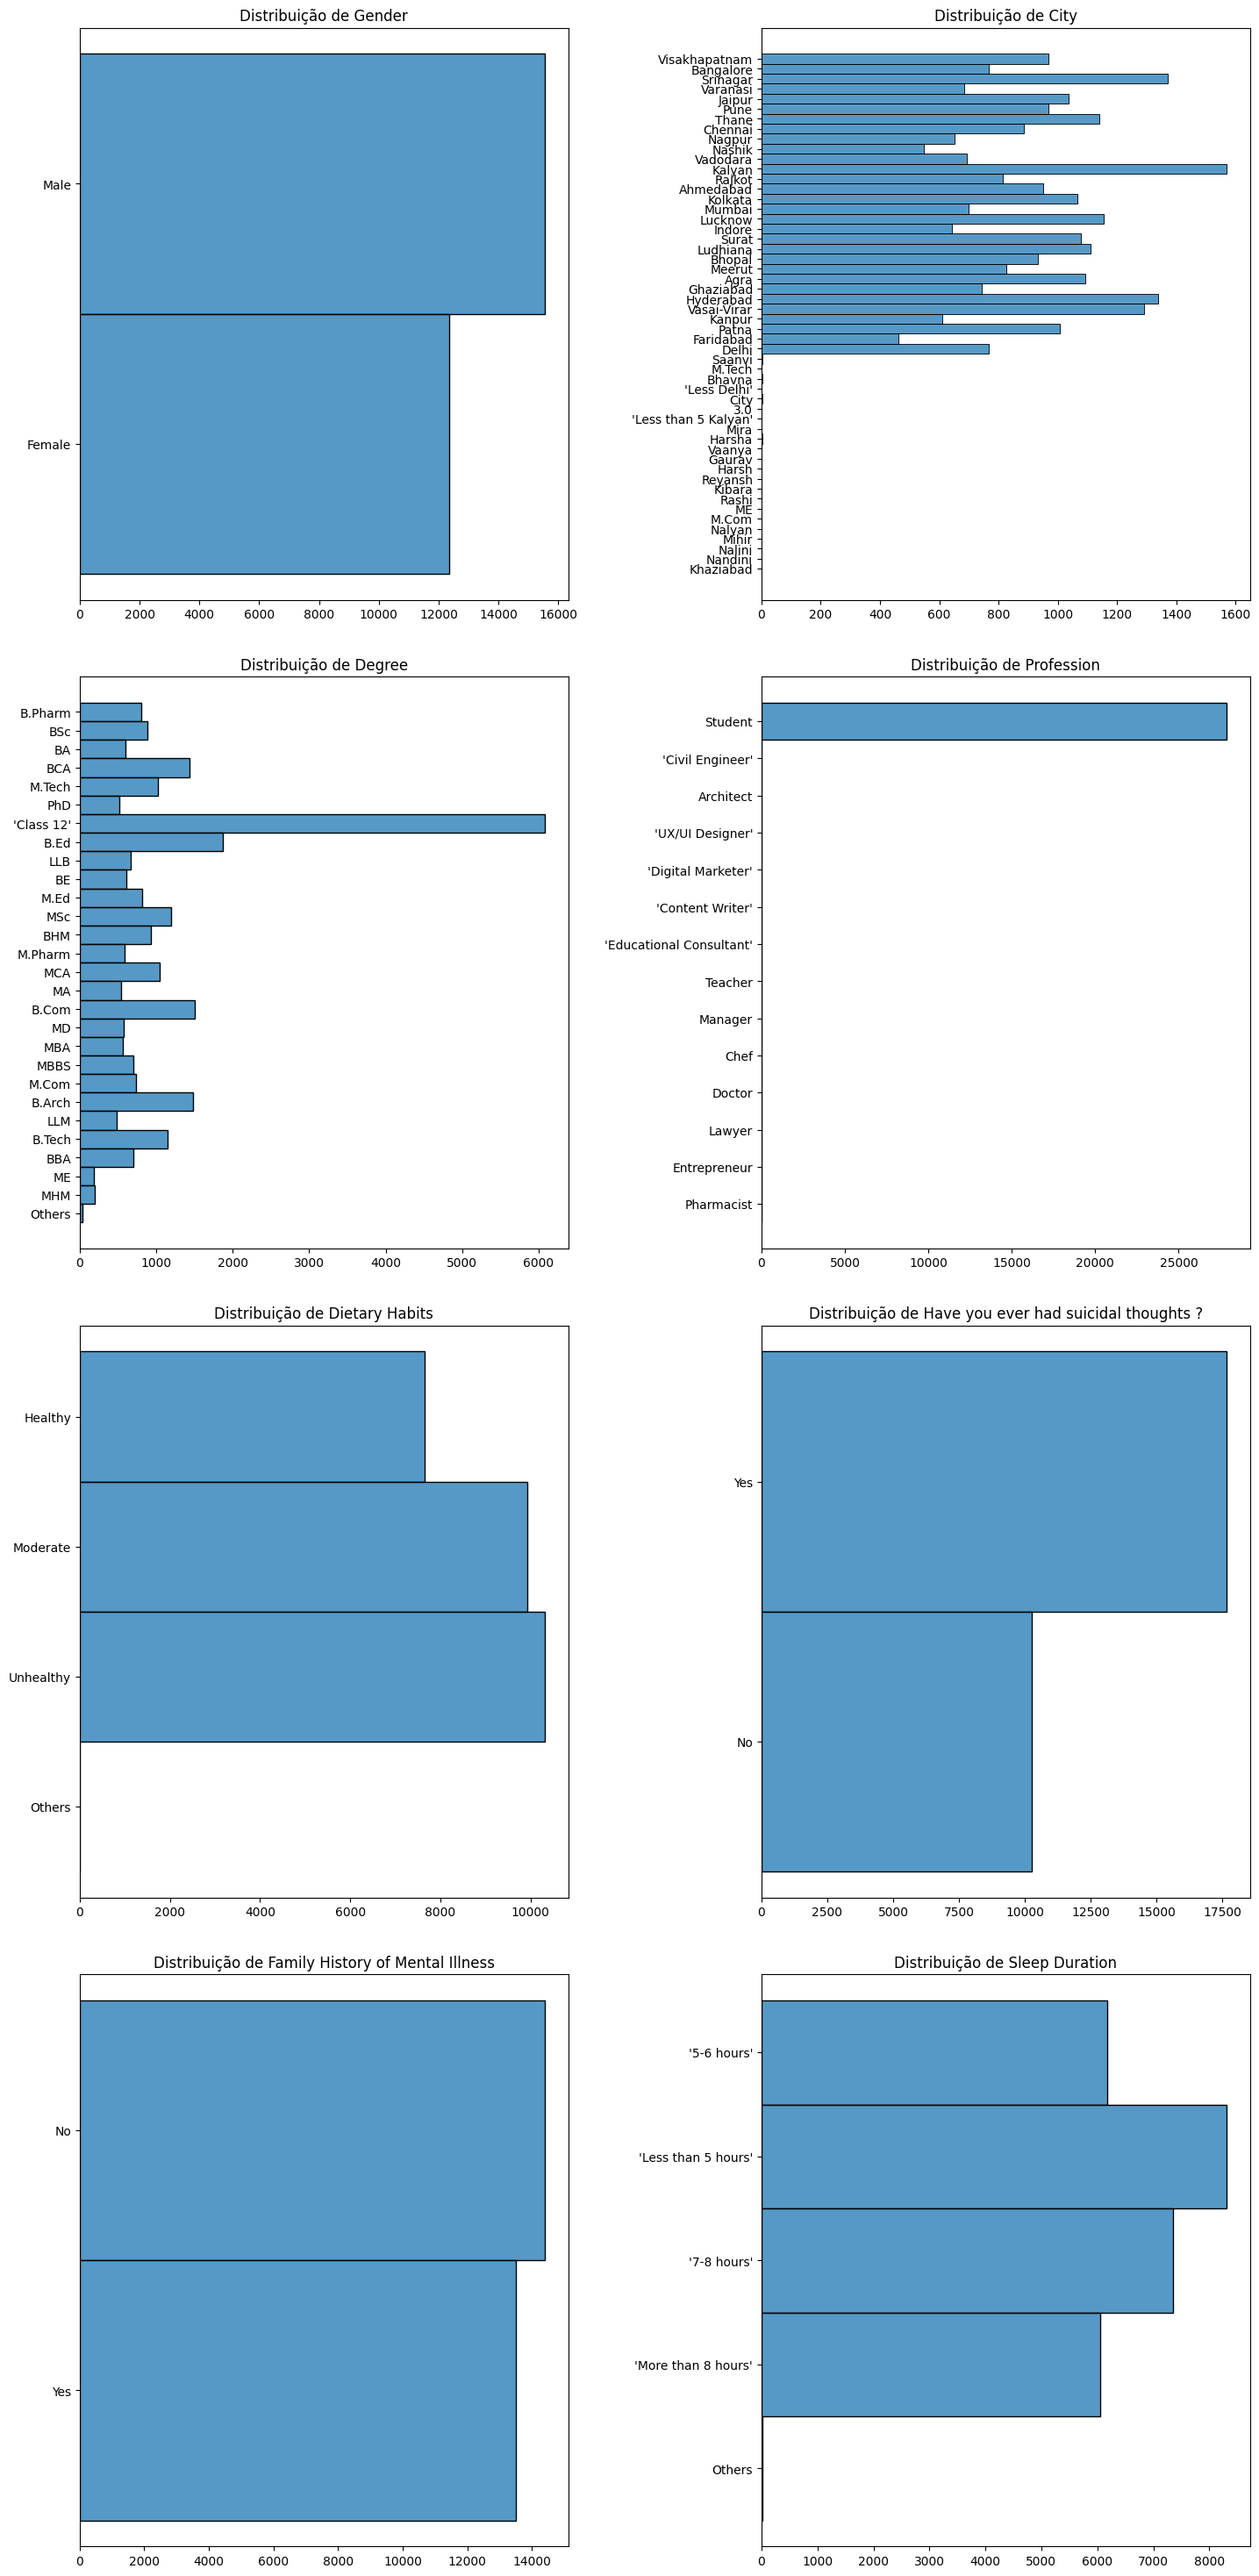

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

n_rows = 4
n_columns = 2
fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 30))

for feature, ax in zip(categorical_features, axes.flatten()):
    sns.histplot(data=df, y=feature, ax=ax)
    ax.set_title(f'Distribuição de {feature}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('')

for i in range(len(numerical_features), n_rows * n_columns):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout(pad=3.0)

plt.show()


## Dataset processing

In [ ]:
df.rename(columns={'Depression': 'target'}, inplace=True)

# Remove colunas
## id
df.drop('id', axis=1, inplace=True)

## Cidade
df.drop('City', axis= 1, inplace=True)

## Curso
df.drop('Degree', axis=1, inplace=True)

# Limpando dados invalidos
df = df[df['Financial Stress'] != '?']
df = df.dropna()

student_work = 'estuda/trabalha'

profession_mapper = {'Student': 'Estudante'}
gender_mapper = {'Male': 'Masculino', 'Female': 'Feminino'}
sleep_duration_mapper = {
    "'5-6 hours'": "5-6 horas",
    "'Less than 5 hours'": "Menos de 5 horas",
    "'7-8 hours'": "7-8 horas",
       "'More than 8 hours'": "Mais de 8 horas"
    }
dietary_habits_mapper = {
    'Healthy': 'Muito saudáveis', 'Moderate': 'Moderadamente saudáveis', 'Unhealthy': 'Pouco saudáveis'
}
yes_no_mapper = {
    'Yes': 'Sim',
    'No': 'Não'
}


df['Gender'] = df['Gender'].map(gender_mapper)
df['Sleep Duration'] = df['Sleep Duration'].map(sleep_duration_mapper)
df['Dietary Habits'] = df['Dietary Habits'].map(dietary_habits_mapper)
df['Have you ever had suicidal thoughts ?'] = df['Have you ever had suicidal thoughts ?'].map(yes_no_mapper)
df['Family History of Mental Illness'] = df['Family History of Mental Illness'].map(yes_no_mapper)
df.drop('Job Satisfaction', axis=1, inplace=True)
df.drop('Work Pressure', axis=1, inplace=True)

df = df.dropna()

df.drop('Profession', axis=1, inplace=True)


X = df.drop('target', axis=1)
Y = df['target']

categorical_features = ['Gender', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
numerical_features = ['Age', 'CGPA', 'Study Satisfaction', 'Academic Pressure', 'Financial Stress', 'Work/Study Hours']


df.head()

,Gender,Age,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Work/Study Hours,Financial Stress,Family History of Mental Illness,target
0,Masculino,33.0,5.0,8.97,2.0,5-6 horas,Muito saudáveis,3.0,1.0,Não,1
1,Feminino,24.0,2.0,5.90,5.0,5-6 horas,Moderadamente saudáveis,3.0,2.0,Sim,0
2,Masculino,31.0,3.0,7.03,5.0,Menos de 5 horas,Muito saudáveis,9.0,1.0,Sim,0
3,Feminino,28.0,3.0,5.59,2.0,7-8 horas,Moderadamente saudáveis,4.0,5.0,Sim,1
4,Feminino,25.0,4.0,8.13,3.0,5-6 horas,Moderadamente saudáveis,1.0,1.0,Não,0


## Training

### Processor setup

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)


In [ ]:
from sklearn.svm import SVC


svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
])

svm_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'CGPA',
                                                   'Study Satisfaction',
                                                   'Academic Pressure',
                                                   'Financial Stress',
                                                   'Work/Study Hours']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Sleep Duration',
                                                   'Dietary Habits',
                                                   'Family History of Mental '
                                                   'Illness'])])),
                ('classifier', SVC(probability=True, random_state=42))])

In [ ]:
from sklearn.ensemble import RandomForestClassifier


random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

random_forest_pipeline.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'CGPA',
                                                   'Study Satisfaction',
                                                   'Academic Pressure',
                                                   'Financial Stress',
                                                   'Work/Study Hours']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Sleep Duration',
                                                   'Dietary Habits',
                                                   'Family History of Mental '
                                                   'Illness'])])),
                ('classifier', RandomForestClassifier())])

In [ ]:
from sklearn.neural_network import MLPClassifier


mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier())
])

mlp_pipeline.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['Age', 'CGPA',
                                                   'Study Satisfaction',
                                                   'Academic Pressure',
                                                   'Financial Stress',
                                                   'Work/Study Hours']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Sleep Duration',
                                                   'Dietary Habits',
                                                   'Family History of Mental '
                                                   'Illness'])])),
                ('classifier', MLPClassifier())])

## Model analysis

### Score

In [ ]:

from sklearn.metrics import accuracy_score, recall_score

def print_score(model, name, X_test, Y_test):
  Y_pred = model.predict(X_test)
  accuracy = accuracy_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  print(f"Acurácia do modelo {name}: {accuracy}")
  print(f"Recall do modelo {name}: {recall}")
  print("\n")

print_score(svm_pipeline, 'SVM', X_test, Y_test)
print_score(random_forest_pipeline, 'Random Forest', X_test, Y_test)
print_score(mlp_pipeline, 'MLP', X_test, Y_test)


Acurácia do modelo SVM: 0.8040904198062433
Recall do modelo SVM: 0.8680316237583621


Acurácia do modelo Random Forest: 0.7918909221385002
Recall do modelo Random Forest: 0.8404621933914453


Acurácia do modelo MLP: 0.7960770242793924
Recall do modelo MLP: 0.8546523413744171




### Análise especifica do SVM

In [ ]:

clf = svm_pipeline.named_steps['classifier']
print(f"Vetores de suporte: {len(clf.support_vectors_)}")
print(f"Vetores de suporte por classe: {clf.n_support_}")


Vetores de suporte: 9359
Vetores de suporte por classe: [4607 4752]


#### Importancia de cada feature

In [ ]:
"""
Análise Detalhada - Importância das Features no Modelo SVM NÃO LINEAR
Focado em técnicas compatíveis com kernels RBF e não lineares
"""

import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.inspection import permutation_importance

def analyze_svm_nonlinear_features(pipeline, X_test, Y_test):
    """
    Análise completa da importância das features para SVM não linear
    Usa Permutation Importance como método principal
    """
    print("="*80)
    print("ANÁLISE DETALHADA - MODELO SVM NÃO LINEAR")
    print("Projeto: Predição de Depressão Estudantil")
    print("="*80)

    # # Carregar modelo
    # model_path = Path("resources/student-depression-svm.joblib")
    # model = joblib.load(model_path)

    print(f"✅ Modelo carregado: {type(pipeline)}")
    print(f"📊 Número de features: {len(pipeline.feature_names_in_)}")

    # Verificar informações do modelo
    svm_classifier = pipeline.named_steps['classifier']
    print(f"🔧 Kernel: {svm_classifier.kernel.upper()}")
    print(f"🎯 Kernel adequado para análise não linear: {'✅' if svm_classifier.kernel != 'linear' else '❌'}")
    print(f"⚖️  Regularização (C): {svm_classifier.C}")
    print(f"📏 Class weight: {svm_classifier.class_weight}")

    if svm_classifier.kernel == 'rbf':
        print(f"🌀 Gamma: {svm_classifier.gamma}")
    print()

    # Mapear para nomes em português do questionário
    feature_mapping = {
        'Gender': 'Gênero',
        'Age': 'Idade',
        'CGPA': 'Coeficiente de Rendimento (CR)',
        'Sleep Duration': 'Duração do Sono',
        'Dietary Habits': 'Hábitos Alimentares',
        'Have you ever had suicidal thoughts ?': 'Pensamentos Suicidas',
        'Work/Study Hours': 'Horas de Estudo/Trabalho',
        'Financial Stress': 'Estresse Financeiro',
        'Family History of Mental Illness': 'Histórico Familiar',
        'Study Satisfaction': 'Satisfação com os Estudos',
        'Academic Pressure': 'Pressão Academica'
    }

    print("🔍 1. ANÁLISE PARA MODELO NÃO LINEAR")
    print("="*80)
    print("💡 MODELOS NÃO LINEARES (RBF, Polynomial):")
    print("   • Não possuem coeficientes interpretáveis diretamente")
    print("   • Usamos Permutation Feature Importance")
    print("   • Mede impacto na performance quando feature é embaralhada")
    print("   • Funciona para qualquer tipo de modelo")
    print()

    # Calcular Permutation Importance
    print("🔍 Calculando Permutation Feature Importance...")
    print("   (Método principal para modelos não lineares)")
    print()

    perm_importance = permutation_importance(
        pipeline, X_test, Y_test,
        n_repeats=50,  # Mais repetições para maior precisão
        random_state=42,
        scoring='accuracy'
    )

    # Organizar resultados
    perm_df = pd.DataFrame({
        'Feature': pipeline.feature_names_in_,
        'Importância': perm_importance.importances_mean,
        'Desvio_Padrão': perm_importance.importances_std,
        'Importância_Percentual': (perm_importance.importances_mean / perm_importance.importances_mean.sum()) * 100,
        'Confiabilidade': perm_importance.importances_mean / (perm_importance.importances_std + 1e-10)  # Evitar divisão por zero
    }).sort_values('Importância', ascending=False)

    perm_df['Feature_PT'] = perm_df['Feature'].map(feature_mapping)

    print("📊 RANKING DE IMPORTÂNCIA DAS FEATURES:")
    print("-" * 80)
    for i, (_, row) in enumerate(perm_df.iterrows(), 1):
        bar_length = max(1, int(row['Importância_Percentual'] * 40 / 100))
        bar = "█" * bar_length + "░" * (40 - bar_length)

        # Determinar nível de confiabilidade
        conf_level = "🟢 ALTA" if row['Confiabilidade'] > 2 else "🟡 MÉDIA" if row['Confiabilidade'] > 1 else "🔴 BAIXA"

        print(f"{i:2d}. {row['Feature_PT']:<30} │{bar}│ {row['Importância_Percentual']:5.1f}%")
        print(f"    Importância: {row['Importância']:.4f} (±{row['Desvio_Padrão']:.4f}) | Conf: {conf_level}")
        print()

    # Análise estatística
    print("📈 2. ANÁLISE ESTATÍSTICA DA IMPORTÂNCIA")
    print("="*80)

    top_features = perm_df.head(5)
    significant_features = perm_df[perm_df['Confiabilidade'] > 1.5]

    print(f"🎯 TOP 5 FEATURES MAIS IMPORTANTES:")
    print("-" * 50)
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        significance = "***" if row['Confiabilidade'] > 3 else "**" if row['Confiabilidade'] > 2 else "*"
        print(f"   {i}. {row['Feature_PT']:<25} {significance}")
        print(f"      └─ Impacto: {row['Importância_Percentual']:.1f}% (±{row['Desvio_Padrão']*100:.1f}%)")

    print(f"\n🔍 FEATURES ESTATISTICAMENTE SIGNIFICATIVAS:")
    print("-" * 50)
    print(f"📊 Total de features significativas: {len(significant_features)}/12")
    for _, row in significant_features.iterrows():
        print(f"   • {row['Feature_PT']:<25} (Conf: {row['Confiabilidade']:.1f})")

    # Análise por categoria de impacto
    print(f"\n🎯 3. CATEGORIZAÇÃO POR IMPACTO")
    print("="*80)

    high_impact = perm_df[perm_df['Importância_Percentual'] > 15]
    medium_impact = perm_df[(perm_df['Importância_Percentual'] >= 5) & (perm_df['Importância_Percentual'] <= 15)]
    low_impact = perm_df[perm_df['Importância_Percentual'] < 5]

    print(f"🔴 ALTO IMPACTO (>15%): {len(high_impact)} features")
    for _, row in high_impact.iterrows():
        print(f"   • {row['Feature_PT']:<25} {row['Importância_Percentual']:5.1f}% 🚨")

    print(f"\n🟡 MÉDIO IMPACTO (5-15%): {len(medium_impact)} features")
    for _, row in medium_impact.iterrows():
        print(f"   • {row['Feature_PT']:<25} {row['Importância_Percentual']:5.1f}% ⚠️")

    print(f"\n🟢 BAIXO IMPACTO (<5%): {len(low_impact)} features")
    for _, row in low_impact.iterrows():
        print(f"   • {row['Feature_PT']:<25} {row['Importância_Percentual']:5.1f}% ✅")

    # Interpretação clínica
    print(f"\n🏥 4. INTERPRETAÇÃO CLÍNICA")
    print("="*80)

    print("💡 INSIGHTS PARA MODELOS NÃO LINEARES:")
    print("-" * 50)

    # Analisar o top 3
    top_3 = perm_df.head(3)
    for i, (_, row) in enumerate(top_3.iterrows(), 1):
        feature_name = row['Feature']
        pt_name = row['Feature_PT']
        importance = row['Importância_Percentual']

        print(f"{i}. {pt_name} ({importance:.1f}%)")

        # Interpretações específicas
        if 'suicidal' in feature_name.lower():
            print("   └─ 🚨 CRÍTICO: Indicador direto de risco suicida")
            print("   └─ 💡 Ação: Triagem prioritária e acompanhamento especializado")
        elif 'pressure' in feature_name.lower():
            print("   └─ ⚠️  ESTRESSE: Pressão acadêmica/profissional")
            print("   └─ 💡 Ação: Programas de manejo de estresse")
        elif 'satisfaction' in feature_name.lower():
            print("   └─ 😔 INSATISFAÇÃO: Baixa satisfação geral")
            print("   └─ 💡 Ação: Atividades de engajamento e motivação")
        elif 'financial' in feature_name.lower():
            print("   └─ 💰 FINANCEIRO: Estresse econômico")
            print("   └─ 💡 Ação: Orientação financeira e bolsas")
        elif 'sleep' in feature_name.lower():
            print("   └─ 😴 SONO: Padrões de sono inadequados")
            print("   └─ 💡 Ação: Higiene do sono e rotina")
        else:
            print("   └─ 📊 Fator significativo para predição")
        print()

    # Recomendações
    print("🎯 5. RECOMENDAÇÕES BASEADAS NA ANÁLISE")
    print("="*80)

    print("✅ VANTAGENS DO MODELO NÃO LINEAR:")
    print("   • Captura interações complexas entre features")
    print("   • Pode modelar relações não lineares")
    print("   • Melhor para padrões complexos nos dados")
    print()

    print("🔧 COMO USAR OS RESULTADOS:")
    print("   • Foque nas features com alta importância percentual")
    print("   • Considere apenas features com alta confiabilidade")
    print("   • Use para priorizar coleta de dados")
    print("   • Guie intervenções preventivas")
    print()

    print("⚠️  LIMITAÇÕES DO MODELO NÃO LINEAR:")
    print("   • Menos interpretável que modelos lineares")
    print("   • Não mostra direção da influência (+ ou -)")
    print("   • Mais propenso a overfitting")
    print("   • Computacionalmente mais pesado")

    print(f"\n" + "="*80)
    print("✅ ANÁLISE DETALHADA CONCLUÍDA - MODELO SVM NÃO LINEAR")
    print("="*80)

    return perm_df



In [ ]:
analyze_svm_nonlinear_features(svm_pipeline, X_test, Y_test)

ANÁLISE DETALHADA - MODELO SVM NÃO LINEAR
Projeto: Predição de Depressão Estudantil
✅ Modelo carregado: <class 'sklearn.pipeline.Pipeline'>
📊 Número de features: 10
🔧 Kernel: RBF
🎯 Kernel adequado para análise não linear: ✅
⚖️  Regularização (C): 1.0
📏 Class weight: None
🌀 Gamma: scale

🔍 1. ANÁLISE PARA MODELO NÃO LINEAR
💡 MODELOS NÃO LINEARES (RBF, Polynomial):
   • Não possuem coeficientes interpretáveis diretamente
   • Usamos Permutation Feature Importance
   • Mede impacto na performance quando feature é embaralhada
   • Funciona para qualquer tipo de modelo

🔍 Calculando Permutation Feature Importance...
   (Método principal para modelos não lineares)

📊 RANKING DE IMPORTÂNCIA DAS FEATURES:
--------------------------------------------------------------------------------
 1. Pressão Academica              │████████████████████░░░░░░░░░░░░░░░░░░░░│  51.6%
    Importância: 0.1410 (±0.0040) | Conf: 🟢 ALTA

 2. Estresse Financeiro            │████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░│

,Feature,Importância,Desvio_Padrão,Importância_Percentual,Confiabilidade,Feature_PT
2,Academic Pressure,0.141029,0.004003,51.612084,35.232281,Pressão Academica
8,Financial Stress,0.057828,0.003619,21.163257,15.979040,Estresse Financeiro
1,Age,0.023399,0.002686,8.563350,8.710089,Idade
7,Work/Study Hours,0.016089,0.002327,5.888069,6.913755,Horas de Estudo/Trabalho
6,Dietary Habits,0.013405,0.002077,4.905849,6.455107,Hábitos Alimentares
4,Study Satisfaction,0.010678,0.002171,3.907871,4.918567,Satisfação com os Estudos
5,Sleep Duration,0.006619,0.001713,2.422285,3.864506,Duração do Sono
9,Family History of Mental Illness,0.002368,0.001328,0.866665,1.783567,Histórico Familiar
3,CGPA,0.001689,0.001291,0.618046,1.307712,Coeficiente de Rendimento (CR)
0,Gender,0.000144,0.000924,0.052525,0.155282,Gênero


## Export

In [ ]:
import joblib

svm_model_output_filename = 'student-depression-svm.joblib'

joblib.dump(svm_pipeline, svm_model_output_filename)


['student-depression-svm.joblib']